In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from Utils.dataset import PreloadedDataset
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
dataset = datasets.MNIST(root='../Datasets/', train=True, transform=transforms.ToTensor(), download=True)
t_dataset = datasets.MNIST(root='../Datasets/', train=False, transform=transforms.ToTensor(), download=True)

VAL_RATIO = 0.2
n_val = int(len(dataset) * VAL_RATIO)
n_train = len(dataset) - n_val
train_set, val_set = torch.utils.data.random_split(dataset, [n_train, n_val])

# transform = transforms.Normalize((0.1307,), (0.3081,))
transform = None

train_set = PreloadedDataset.from_dataset(train_set, transform, device)
val_set = PreloadedDataset.from_dataset(val_set, transform, device)
test_set = PreloadedDataset.from_dataset(t_dataset, transform, device)

In [4]:
def train(
        model,
        train_set,
        val_set,
        optimizer,
        criterion,
        n_epochs,
        batch_size,
):
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

    train_losses = []
    val_losses = []

    for epoch in range(n_epochs):
        loop = tqdm(enumerate(train_loader), total=len(train_loader), leave=False)
        model.train()
        train_loss = 0
        for _, (x, _) in loop:
            if epoch > 0:
                loop.set_description(f'Epoch [{epoch}/{n_epochs}]')
                loop.set_postfix(train_loss=train_losses[-1], val_loss=val_losses[-1])

            x_hat, mu, log_sigma = model(x)

            reconstruction_loss = criterion(x_hat, x)
            # kl_div = -0.5 * torch.sum(1 + torch.log(sigma.pow(2)) - mu.pow(2) - sigma.pow(2))
            kl_div = -0.5 * torch.sum(log_sigma - torch.exp(log_sigma) - torch.square(mu) + 1)
            loss = reconstruction_loss + kl_div
            train_loss += loss.item()
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        train_losses.append(train_loss / len(train_loader))

        with torch.no_grad():
            model.eval()
            val_loss = 0
            for x, _ in val_loader:
                x_hat, mu, log_sigma = model(x)

                reconstruction_loss = criterion(x_hat, x)
                kl_div = -0.5 * torch.sum(log_sigma - torch.exp(log_sigma) - torch.square(mu) + 1)
                loss = reconstruction_loss + kl_div
                val_loss += loss.item()

            val_losses.append(val_loss / len(val_loader))
        
    return train_losses, val_losses

In [33]:
Z_DIM = 20
H_DIM = 200
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        # Encoder
        self.img2hid = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784, H_DIM),
        )
        self.hid2mu = nn.Linear(H_DIM, Z_DIM)
        self.hid2sigma = nn.Linear(H_DIM, Z_DIM)

        # Decoder
        self.z2hid = nn.Linear(Z_DIM, H_DIM)
        self.hid2img = nn.Sequential(
            nn.Linear(H_DIM, 784),
            nn.Unflatten(1, (1, 28, 28)),
        )
    
    def encode(self, x):
        x = torch.relu(self.img2hid(x))
        mu, log_sigma = self.hid2mu(x), self.hid2sigma(x)
        return mu, log_sigma
    
    def decode(self, z):
        z = torch.relu(self.z2hid(z))
        return torch.sigmoid(self.hid2img(z))
    

    def forward(self, x):
        mu, log_sigma = self.encode(x)
        eps = torch.randn_like(log_sigma)
        z = mu + torch.exp(log_sigma) * eps
        x_hat = self.decode(z)
        return x_hat, mu, log_sigma
    
model = VAE().to(device)

In [34]:
LR = 0.001
EPOCHS = 30
BATCH_SIZE = 64

criterion = nn.BCELoss(reduction="sum")
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

train_losses, val_losses = train(model, train_set, val_set, optimizer, criterion, EPOCHS, BATCH_SIZE)

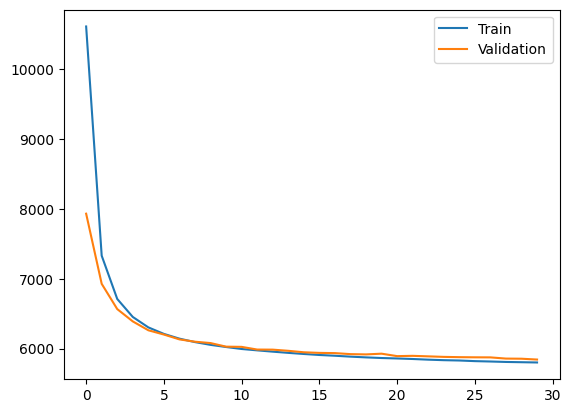

In [35]:
# Plot losses
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.legend()
plt.show()

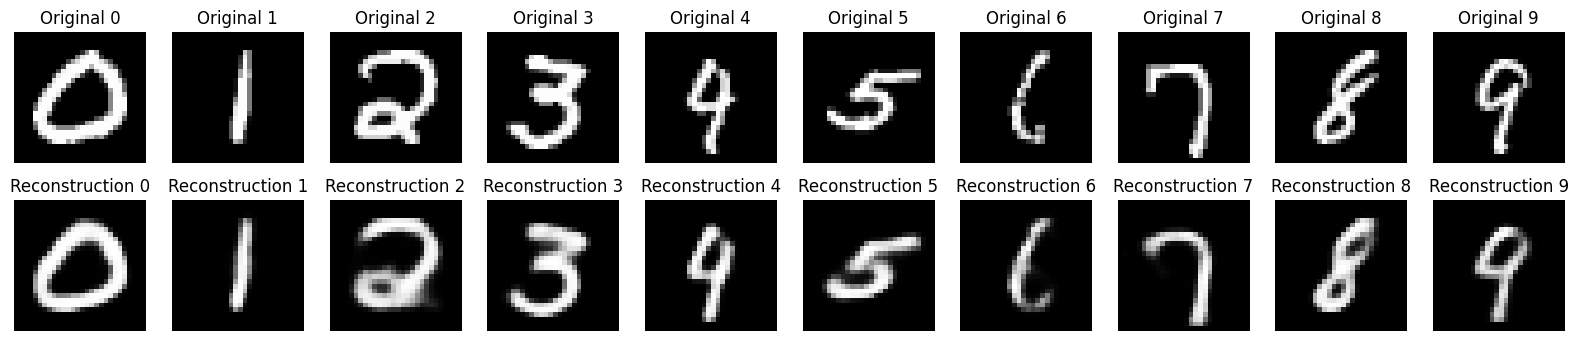

In [36]:
# Collect 1 image per class
images = {}
while len(images) < 10:
    idx = torch.randint(0, len(test_set), (1,)).item()
    x, y = test_set[idx]
    if y not in images:
        images[y.item()] = x

# Reconstruct images
reconstructions = {}
for y, x in images.items():
    x_hat, _, _ = model(x.unsqueeze(0))
    reconstructions[y] = x_hat.squeeze(0)

# Plot images
fig, axs = plt.subplots(2, 10, figsize=(20, 4))
for i in range(10):
    axs[0, i].imshow(images[i].cpu().numpy().squeeze(), cmap='gray')
    axs[1, i].imshow(reconstructions[i].cpu().detach().numpy().squeeze(), cmap='gray')
    axs[0, i].set_title(f'Original {i}')
    axs[1, i].set_title(f'Reconstruction {i}')
    axs[0, i].axis('off')
    axs[1, i].axis('off')
plt.show()